In [12]:
import mermaid as md
from mermaid.graph import Graph

#sequence = Graph('Sequence-diagram',"""
# %%{init: {'themeVariables': { 'fontSize': '10px' }}}%%
# %%{init: {'theme': 'base', 'themeVariables': { 'darkMode': false, 'fontSize': '10px' }}}%%
#%%{init: {'themeVariables': {'nodeWidth': 800, 'wrap': false, 'fontSize': '20px'}}}%%
# %%{init: {'themeVariables': {'nodeSpacing': 50, 'padding': 15}}}%%

sequence = Graph('flowchart',"""
flowchart TB
    0@{ shape: diamond, label: "Do you have a structure of the modified protein with all hydrogens added?" }
    0-->|No|0A
    0-->|Yes|1
    
    0A@{ shape: rectangle, label: "All OpenFF protein loading methods require explicit hydrogens to be present. Consider using PDBFixer, pdb2pqr, or another protein preparation tool."}
    0A-->|Ok, I've added explicit hydrogens|1
    
    1@{ shape: diamond, label: "Do you have a RDKit or OpenEye Molecule of your modified protein?" }
    1-->|Yes|1A
    1-->|No|2

    1A@{ shape: rectangle, label: "<pre style='white-space: pre-wrap; text-align: left; width: 400px;'>offmol = Molecule.from_rdkit(rdmol)
    # or
    offmol = Molecule.from_openeye(oemol)
    # and finally
    top = offmol.to_topology()</pre>"}
    1A-->20

    2@{ shape: diamond, label: "Do you have an SDF file of the modified protein?"}
    2-->|Yes|2A
    2-->|No|2P5
    
    2A@{ shape: diamond, label: "Do you ALSO have a PDB file with residue information that you want to preserve in the final OpenFF Molecule?"}
    2A-->|Yes|2AA
    2A-->|No|2AB


    2AA@{ shape: rectangle, label: "<pre style='white-space: pre-wrap; text-align: left; width: 1000px;'>ref_mol = Molecule.from_file('protein.sdf')
    from openmm.app import PDBFile
    pdb = PDBFile('protein.pdb')
    top = Topology.from_openmm(pdb.topology, unique_molecules=[ref_mol], positions=pdb.positions)</pre>"}
    2AA-->20
    
    2AB@{ shape: rectangle, label: "<pre style='white-space: pre-wrap; text-align: left; width: 500px;'>offmol = Molecule.from_file('protein.sdf')
    #(then optionally)
    offmol.percieve_residues()
    # and finally
    top = offmol.to_topology()</pre>"}
    2AB-->20
    
    2P5@{ shape: rectangle, label: "You must have SDF/SMILES of at least modification, if not the whole residue (for CCD residues, you can download the 'ideal' SDF from RCSB PDB)"}
    2P5-->|Yes|3
    
    3@{ shape: diamond, label: "Do you have a PDB file with CONECT records for the modified residue?"}
    3-->|Yes|4
    3-->|No|14
    
    4@{ shape: diamond, label: "Is the modified residue a conjugated cysteine?"}
    4-->|Yes|5
    4-->|No|6

    5@{ shape: rectangle, label: "<pre style='white-space: pre-wrap; text-align: left; width: 900px;'>mol = Molecule.from_file('maleimide_hydrogenated.sdf')
# Mark leaving hydrogen where the bond will be made to the cysteine
for atom in mol.atoms:
&nbsp;&nbsp;&nbsp;&nbsp;atom.metadata['substructure_atom'] = True
smarts = 'C(=O)C([H:1])CC(=O)'
# Since this pattern will be found multiple times due to symmetry, only use 
# the first match ([0}) to identify a single leaving hydrogen. 
&nbsp;&nbsp;&nbsp;&nbsp;print(f'marking {atom_idx=} as leaving')
&nbsp;&nbsp;&nbsp;&nbsp;mol.atom(atom_idx).metadata['substructure_atom'] = False
top = Topology.from_pdb('3ip9_dye.pdb', _additional_substructures=[mol])</pre>"}
    5-->20
    
    6@{ shape: diamond, label: "Does the ENTIRE modified residue have CONECT records (not just the covalent attachment)?"}
    6-->|Yes|7
    6-->|No|14

    7@{ shape: diamond, label: "Do you have an SDF/SMILES of the ENTIRE modified residue (including backbone atoms)?"}
    7-->|Yes|10
    7-->|No|8

    8@{ shape: diamond, label: "Do you have an SDF/SMILES of the covalent attachment?"}
    8-->|Yes|9
    8-->|No|17

    9@{ shape: rectangle, label: "<pre style='white-space: pre-wrap; text-align: left; width: 1000px;'>from ptm_prototype import react
from openff.pablo import ccd, CCD_RESIDUE_DEFINITION_CACHE
# Load canonical form of residue from CCD cache
cysteine = CCD_RESIDUE_DEFINITION_CACHE['CYS'][0].to_openff_molecule()
# Load covalent attachment
maleimide = Molecule.from_file('maleimide.sdf')
# Define the reaction that conjugates the canonical residue to the covalent attachment
thiol_maleimide_click_smarts = (
    '[C:10]-[S:1]-[H:2]'
    + '.'
    + '[N:3]1-[C:4](=[O:5])-[C:6](-[H:11])=[C:7](-[H:12])-[C:8](=[O:9])-1'
    + '>>'
    + '[N:3]1-[C:4](=[O:5])-[C:6](-[H:2])(-[H:11])-[C@:7](-[S:1]-[C:10])(-[H:12])-[C:8](=[O:9])-1'
)
# Run the reaction, generate a conformer, and save the file
products = react([cysteine, maleimide], thiol_maleimide_click_smarts)
mod_res = [*products][0][0]
mod_res.generate_conformers()
mod_res.to_file('CYS-MAL.sdf', file_format='sdf')</pre>"}

    9-->10
    
    10@{ shape: rectangle, label: "<pre style='white-space: pre-wrap; text-align: left; width: 900px;'>mod_res = Molecule.from_file('CYS-MAL.sdf')
# Mark leaving hydrogen where the bond will be made to the cysteine
for atom in mod_res.atoms:
&nbsp;&nbsp;&nbsp;&nbsp;atom.metadata['substructure_atom'] = True
backbone_smarts = '[H:1][NH2X3][CH1X4][CH0X3](=[OH0X1])[OX2H1:2][H:3]'
# Since this pattern will be found multiple times due to symmetry, only use 
#the first match ([0}) to identify a single leaving hydrogen. 
for atom_idx in mod_res.chemical_environment_matches(backbone_smarts)[0]:
&nbsp;&nbsp;&nbsp;&nbsp;print(f'marking {atom_idx=} as leaving')
&nbsp;&nbsp;&nbsp;&nbsp;mod_res.atom(atom_idx).metadata['substructure_atom'] = False
top = Topology.from_pdb('3ip9_dye.pdb', _additional_substructures=[mod_res])
</pre>"}
    10-->20

    14@{ shape: rectangle, label: "Follow the instructions in our <a href='https://github.com/openforcefield/ptm_prototype' target='_blank'>PTM Prototype notebook</a>"}
    

    17@{ shape: rectangle, label: "Please write in to our <a href='https://github.com/openforcefield/ptm_prototype/issues' target='_blank'>issue tracker</a> and let us know which representation of your modified amino acid/covalent attachment you DO have."}
    17-->14

    20@{ shape: rectangle, label: "To solvate and assign parameters to the loaded Topology, start at the 'Solvate' or 'Parameterize' step in our <a href='https://github.com/openforcefield/ptm_prototype' target='_blank'>PTM Prototype notebook</a>"}



""")
render = md.Mermaid(sequence)
render # !! note this only works in the notebook that rendered the html.

In [ ]:
import numpy as np
type(round(np.float64(2.2)))

In [ ]:
from openff.toolkit import Molecule, Topology

In [ ]:
# YES CONECT/YES protein SDF/NO preserve metadata
protein = Molecule.from_file("1npz_prot_lig.sdf")
protein.perceive_residues()

In [ ]:
# YES CONECT/YES protein SDF/YES preserve metadata
ref_mol = Molecule.from_file("1npz_prot_lig.sdf")
from openmm.app import PDBFile
pdb = PDBFile('1npz_vanilla_oe_prot-lig.pdb')
top = Topology.from_openmm(pdb.topology, unique_molecules=[ref_mol], positions=pdb.positions)

In [3]:
from openff.toolkit import Molecule, Topology
from ptm_prototype import react

In [ ]:
mol = Molecule.from_file('maleimide.sdf')
h2 = Molecule.from_smiles('[H][H]')
prods = react([h2, mol], "[H:3][H:4].[C:7](=O)-[CX3:1]([H:5])=[CX3:2]([H:6])-[C:8](=O) >> [C:7](=O)-[CX4:1]([H:3])([H:5])-[CX4:2]([H:4])([H:6])-[C:8](=O)")
hydrogenated = [*prods][0][0]
hydrogenated.generate_conformers()
hydrogenated

In [34]:
hydrogenated.to_file('maleimide_hydrogenated.sdf', file_format='sdf')

# 5

In [36]:
mol = Molecule.from_file('maleimide_hydrogenated.sdf')
# Mark leaving hydrogen where the bond will be made to the cysteine
for atom in mol.atoms:
    atom.metadata['substructure_atom'] = True
smarts = 'C(=O)C([H:1])CC(=O)'
# Since this pattern will be found multiple times due to symmetry, only use 
#the first match ([0}) to identify a single leaving hydrogen. 
for atom_idx in mol.chemical_environment_matches(smarts)[0]:
    print(f"marking {atom_idx=} as leaving")
    mol.atom(atom_idx).metadata['substructure_atom'] = False
top = Topology.from_pdb('3ip9_dye.pdb', _additional_substructures=[mol])

marking atom_idx=3 as leaving


# 9

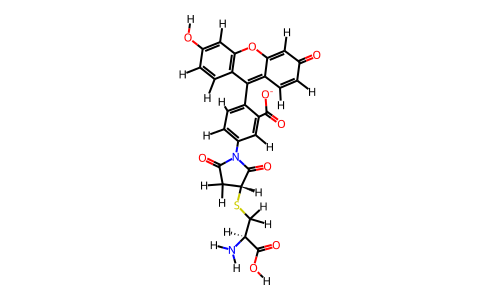

In [55]:
from ptm_prototype import react
from openff.pablo import ccd, CCD_RESIDUE_DEFINITION_CACHE
# Load canonical form of residue from CCD cache
cysteine = CCD_RESIDUE_DEFINITION_CACHE['CYS'][0].to_openff_molecule()
# Load covalent attachment
maleimide = Molecule.from_file('maleimide.sdf')
# Define the reaction that conjugates the canonical residue to the covalent attachment
thiol_maleimide_click_smarts = (
    '[C:10]-[S:1]-[H:2]'
    + '.'
    + '[N:3]1-[C:4](=[O:5])-[C:6](-[H:11])=[C:7](-[H:12])-[C:8](=[O:9])-1'
    + '>>'
    + '[N:3]1-[C:4](=[O:5])-[C:6](-[H:2])(-[H:11])-[C@:7](-[S:1]-[C:10])(-[H:12])-[C:8](=[O:9])-1'
)
# Run the reaction, generate a conformer, and save the file
products = react([cysteine, maleimide], thiol_maleimide_click_smarts)
mod_res = [*products][0][0]
mod_res.generate_conformers()
mod_res.to_file('CYS-MAL.sdf', file_format='sdf')
mod_res.visualize(backend='rdkit')


# 10

In [56]:
mod_res = Molecule.from_file('CYS-MAL.sdf')
# Mark leaving hydrogen where the bond will be made to the cysteine
for atom in mod_res.atoms:
    atom.metadata['substructure_atom'] = True
backbone_smarts = '[H:1][NH2X3][CH1X4][CH0X3](=[OH0X1])[OX2H1:2][H:3]'
# Since this pattern will be found multiple times due to symmetry, only use 
#the first match ([0}) to identify a single leaving hydrogen. 
for atom_idx in mod_res.chemical_environment_matches(backbone_smarts)[0]:
    print(f"marking {atom_idx=} as leaving")
    mod_res.atom(atom_idx).metadata['substructure_atom'] = False
top = Topology.from_pdb('3ip9_dye.pdb', _additional_substructures=[mod_res])


marking atom_idx=18 as leaving
marking atom_idx=21 as leaving
marking atom_idx=22 as leaving


# 15+16

[16:55:58] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


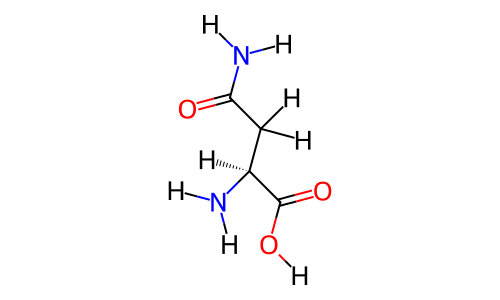

In [2]:
from ptm_prototype import react
from openff.pablo import ccd, CCD_RESIDUE_DEFINITION_CACHE
from openff.toolkit import Molecule, Topology

# Load canonical form of residue from CCD cache
asparagine = CCD_RESIDUE_DEFINITION_CACHE['ASN'][0].to_openff_molecule()
nag = Molecule.from_file('NAG_ideal.sdf')
asparagine

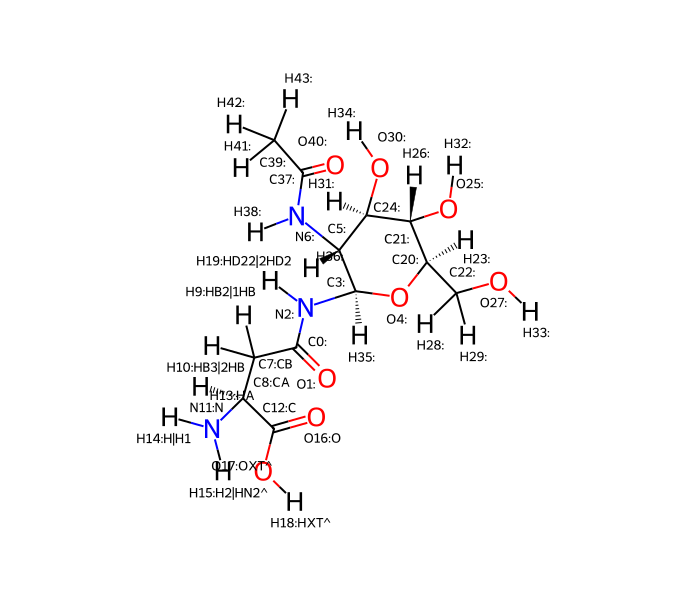

In [3]:
from ptm_prototype import draw_molecule
asn_nag_smarts = (
    '[C:1](=[O:2])[N:3][H:4]'
    + '.'
    + '[O:5][C:6]([O:7][H:8])[C:9][N:10]'
    + '>>'
    + '[C:1](=[O:2])[N:3][C:6]([O:5])[C:9][N:10].[H:4][O:7][H:8]'
)
# Run the reaction, generate a conformer, and save the file
products = react([asparagine, nag], asn_nag_smarts)
mod_res = [*products][0][0]
mod_res.generate_conformers()
mod_res.to_file('ASN_NAG.sdf', file_format='sdf')
#mod_res.visualize(backend='rdkit')
draw_molecule(
    mod_res,
    width=700,
    height=600,
    atom_notes={
        i: (f'{atom.symbol}' +
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(mod_res.atoms)
    },
)

In [4]:
replace_names = {
    19:'HD21',
    2:'ND2',
    0:'CG',
    1:'OD1',
    3:'C1',
    35:'H1',
    4:'O5',
    20:'C5',
    23:'H5',
    22:'C6',
    28:'H61',
    29:'H62',
    27:'O6',
    33:'HO6',
    21:'C4',
    26:'H4',
    25:'O4',
    32:'HO4',
    24:'C3',
    31:'H3',
    30:'O3',
    34:'HO3',
    5:'C2',
    36:'H2',
    6:'N2',
    38:'HN2',
    37:'C7',
    40:'O7',
    39:'C8',
    41:'H81',
    42:'H82',
    43:'H83',
}
for atom_idx, name in replace_names.items():
    mod_res.atom(atom_idx).name = name



CG {'residue_name': 'ASN', 'residue_number': 0, 'insertion_code': '', 'chain_id': '', 'old_mapno': 1, 'react_atom_idx': 5}
OD1 {'residue_name': 'ASN', 'residue_number': 0, 'insertion_code': '', 'chain_id': '', 'old_mapno': 2, 'react_atom_idx': 6}
ND2 {'residue_name': 'ASN', 'residue_number': 0, 'insertion_code': '', 'chain_id': '', 'old_mapno': 3, 'react_atom_idx': 7}
C1 {'old_mapno': 6, 'react_atom_idx': 0}
O5 {'old_mapno': 5, 'react_atom_idx': 12}
C2 {'old_mapno': 9, 'react_atom_idx': 1}
N2 {'old_mapno': 10, 'react_atom_idx': 8}
CB {'residue_name': 'ASN', 'residue_number': 0, 'insertion_code': '', 'chain_id': '', '_Name': 'CB', 'leaving_atom': False, 'substructure_atom': True, 'synonyms': '', 'react_atom_idx': 4}
CA {'residue_name': 'ASN', 'residue_number': 0, 'insertion_code': '', 'chain_id': '', '_CIPCode': 'S', '_Name': 'CA', 'leaving_atom': False, 'substructure_atom': True, 'synonyms': '', 'react_atom_idx': 1}
HB2 {'residue_name': 'ASN', 'residue_number': 0, 'insertion_code': '',

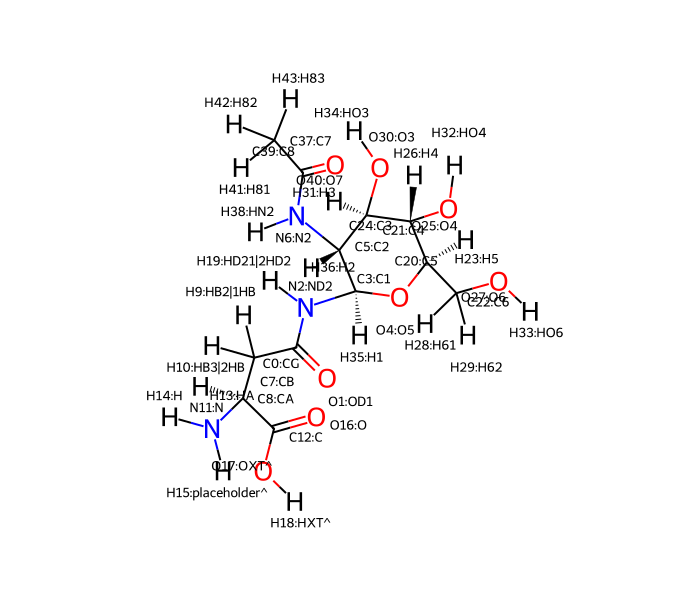

In [5]:
from openff.pablo import ResidueDefinition
from openff.pablo.chem import PEPTIDE_BOND
for atom in mod_res.atoms:
    if 'H1' in atom.metadata.get('synonyms', ''):
        atom.metadata['synonyms'] = ''
    if 'HN2' in atom.metadata.get('synonyms', ''):
        atom.metadata['synonyms'] = ''
    if (atom.name == 'H2') and (atom.metadata.get('leaving_atom', False)):
        atom.name = 'placeholder'
    print(atom.name, atom.metadata)

draw_molecule(
    mod_res,
    width=700,
    height=600,
    atom_notes={
        i: (f'{atom.symbol}' +
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(mod_res.atoms)
    },
)

In [6]:
mod_resdef = ResidueDefinition.from_molecule(
    molecule=mod_res,
    residue_name="LIG",
    linking_bond=PEPTIDE_BOND,
)

In [7]:
import MDAnalysis
u = MDAnalysis.Universe('1byv.pdb')

after_sel = u.select_atoms('(resid 4 to 999) and not (resname NAG)')

asn_sel = u.select_atoms('resname ASN and resid 3')
lig_sel = u.select_atoms('resname NAG')

for atom in asn_sel:
    atom.residue.resname = 'LIG'
    
for atom in lig_sel:
    atom.residue.resname = 'LIG' 
    atom.residue.resid = asn_sel[0].residue.resid

before_sel = u.select_atoms('resid 1 2')
mod_sel = u.select_atoms('resid 3')

all_sel = before_sel + mod_sel + after_sel

all_sel.write('1byv_merged.pdb')

/Users/jeffreywagner/micromamba/envs/openff_ptm_prototype/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/Users/jeffreywagner/micromamba/envs/openff_ptm_prototype/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [8]:
from openff.pablo import CCD_RESIDUE_DEFINITION_CACHE, topology_from_pdb

topology = topology_from_pdb(
    "1byv_merged.pdb",
    residue_database=CCD_RESIDUE_DEFINITION_CACHE.with_({"LIG": [mod_resdef]}),
)

# S1

In [ ]:
# S1: NO protein SDF/YES CONECT/YES mod res SDF/SMILES
#mod_res = Molecule.from_file("maleimide.sdf")
#mod_res.to_smiles()
mod_res = Molecule.from_smiles('[H][O][c]1[c]([H])[c]([H])[c]2[c]([c]1[H])[O][C]1=[C]([H])[C](=[O])[C]([H])=[C]([H])[C]1=[C]2[c]1[c]([H])[c]([H])[c]([N]2[C](=[O])[C@@]([H])(SC[C@@H](N)[C]([O][H])=O)-[C]([H])([H])[C]2=[O])[c]([H])[c]1[C](=[O])[O-]')
mod_res.visualize()

In [ ]:
for atom in mod_res.atoms:
    atom.metadata['substructure_atom'] = True
backbone_smarts = '[H:1][NH2X3][CH1X4][CH0X3](=[OH0X1])[OX2H1:2][H:3]'
for atom_idx in mod_res.chemical_environment_matches(backbone_smarts)[0]:
    print(f"marking {atom_idx=} as leaving")
    mod_res.atom(atom_idx).metadata['substructure_atom'] = False
top = Topology.from_pdb('3ip9_dye.pdb', _additional_substructures=[mod_res])

# S2
Note: This would be better with a modified residue other than CYS

In [ ]:
# S2: NO protein SDF/YES CONECT/NO mod res SDF/YES modification SDF/SMILES

from openff.pablo import CCD_RESIDUE_DEFINITION_CACHE
from rdkit.Chem.rdChemReactions import ReactionFromSmarts
import rdkit
cysteine = CCD_RESIDUE_DEFINITION_CACHE['CYS'][0].to_openff_molecule()
maleimide = Molecule.from_file('maleimide.sdf')
thiol_maleimide_click_smarts = (
    "[C:10]-[S:1]-[H:2]"
    + "."
    + "[N:3]1-[C:4](=[O:5])-[C:6](-[H:11])=[C:7](-[H:12])-[C:8](=[O:9])-1"
    + ">>"
    + "[N:3]1-[C:4](=[O:5])-[C:6](-[H:2])(-[H:11])-[C@:7](-[S:1]-[C:10])(-[H:12])-[C:8](=[O:9])-1"
)
rxn = ReactionFromSmarts(thiol_maleimide_click_smarts)
product_rdmols = rxn.RunReactants([cysteine.to_rdkit(),
                                   maleimide.to_rdkit()])
for products in product_rdmols:
    # Skip products that cannot be sanitized
    try:
        for product in products:
            product.UpdatePropertyCache()
            rdkit.Chem.SanitizeMol(product)
    except rdkit.Chem.rdchem.MolSanitizeException:
        continue
    mod_res = Molecule.from_rdkit(product_rdmols[0][0])
    break

for atom in mod_res.atoms:
    atom.metadata['substructure_atom'] = True
backbone_smarts = '[H:1][NH2X3][CH1X4][CH0X3](=[OH0X1])[OX2H1:2][H:3]'
for atom_idx in mod_res.chemical_environment_matches(backbone_smarts)[0]:
    print(f"marking {atom_idx=} as leaving")
    mod_res.atom(atom_idx).metadata['substructure_atom'] = False
top = Topology.from_pdb('3ip9_dye.pdb', _additional_substructures=[mod_res])



# S3

In [ ]:
# S3: NO protein SDF/NO CONECT/YES mod res is one res num/YES CCD defined residue (Ex TPO)
from openff.pablo import ccd, CCD_RESIDUE_DEFINITION_CACHE, topology_from_pdb
import pathlib
cache = ccd.CcdCache([pathlib.Path('.')], preload=['TPO'])

In [ ]:
mod_res = cache['TPO'][0].to_openff_molecule()
draw_molecule(
    mod_res,
    width=700,
    height=600,
    atom_notes={
        i: (
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(cysteine.atoms)
    },
)

In [ ]:
from ptm_prototype import react

products = list(react([mod_res], '[P:1]([O:2][H:3])[O:4][H:5] >> [P:1]([O-:2])[O-:4]'))
mod_res = products[1][0]


In [ ]:
from ptm_prototype import draw_molecule

draw_molecule(
    mod_res,
    width=700,
    height=600,
    atom_notes={
        i: (
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(cysteine.atoms)
    },
)

In [ ]:
#mod_res = Molecule.from_file('TPO_ideal.sdf')
for atom in mod_res.atoms:
    atom.metadata['leaving_atom'] = False
backbone_smarts = '[H:1][NH2X3][CH1X4][CH0X3](=[OH0X1])[OX2H1:2][H:3]'
for atom_idx in mod_res.chemical_environment_matches(backbone_smarts)[0]:
    print(f"marking {atom_idx=} as leaving")
    mod_res.atom(atom_idx).metadata['leaving_atom'] = True
from openff.pablo import ResidueDefinition
from openff.pablo.chem import PEPTIDE_BOND

mod_resdef = ResidueDefinition.from_molecule(
    molecule=mod_res,
    residue_name="TPO",
    linking_bond=PEPTIDE_BOND,
)

In [ ]:
topology = topology_from_pdb(
    "8sg2.pdb",
    residue_database=CCD_RESIDUE_DEFINITION_CACHE.with_({'TPO':[mod_resdef]}),
)

In [ ]:
# S4: NO protein SDF/NO CONECT/YES mod res is one res num/NO CCD defined residue/YES attachment SDF



In [ ]:
# S5: NO protein SDF/NO CONECT/NO mod res is one res num/base residue is NOT cysteine




In [ ]:
molecule = maleimide
del molecule.properties['atom_map']

In [ ]:
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper
nagl = NAGLToolkitWrapper()
nagl.assign_partial_charges(molecule, "openff-gnn-am1bcc-0.1.0-rc.3.pt")


In [ ]:
from openff.toolkit import ForceField
ff = ForceField('openff-2.2.1.offxml')
smirks = molecule.to_smiles(mapped=True)
charges = molecule.partial_charges

library_charge = ff['LibraryCharges'].LibraryChargeType(
    smirks=smirks,
    charge=charges,
)
print(library_charge)

In [77]:
from openff.toolkit import Molecule, Topology, ForceField
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper
ff=ForceField('openff-2.1.0.offxml')
h2po4 = Molecule.from_smiles('[O-]P(=O)(O)O')
#h2po4.generate_unique_atom_names()
h2po4.generate_conformers(n_conformers=1)
h2po4.assign_partial_charges(partial_charge_method='openff-gnn-am1bcc-0.1.0-rc.3.pt', 
                             toolkit_registry=NAGLToolkitWrapper())
h2po4_top = Topology.from_molecules([h2po4])
inc_h2po4 = ff.create_interchange(h2po4_top,charge_from_molecules=[h2po4])
inc_h2po4.to_pdb("h2po4_inc.pdb")
h2po4_top.to_file("h2po4.pdb")

[12:42:28] WARNING: Proton(s) added/removed



In [79]:
offtop = Topology.from_pdb("h2po4.pdb", unique_molecules=[h2po4])

In [4]:
inc_h2po4.topology

In [1]:
from openmm import app
pdb = app.PDBFile("h2po4_inc.pdb")
[*pdb.topology.atoms()]

/Users/jeffreywagner/micromamba/envs/openff_ptm_prototype/lib/python3.12/site-packages/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM    2      UNK A   1      -0.441  -0.238  -0.049  1.00  0.00           P  , HETATM    1      UNK A   1      -0.800  -0.561   1.557  1.00  0.00           O  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/Users/jeffreywagner/micromamba/envs/openff_ptm_prototype/lib/python3.12/site-packages/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (HETATM    3      UNK A   1      -1.476  -0.867  -0.946  1.00  0.00           O  , HETATM    2      UNK A   1      -0.441  -0.238  -0.049  1.00  0.00           P  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/Users/jeffreywagner/micromamba/envs/openff_ptm_prototyp

[<Atom 0 () of chain 0 residue 0 (UNK)>]

In [ ]:
import mermaid as md
from mermaid.graph import Graph

#sequence = Graph('Sequence-diagram',"""
# %%{init: {'themeVariables': { 'fontSize': '10px' }}}%%
# %%{init: {'theme': 'base', 'themeVariables': { 'darkMode': false }}}%%

sequence = Graph('flowchart',"""
%%{init: {'themeVariables': {'nodeWidth': 500, 'wrap': false}}}%%
flowchart TB
    0@{ shape: diamond, label: "Do you have a structure of the modified protein with all hydrogens added?" }
    0-->|No|0A
    0-->|Yes|1
    0A@{ shape: rectangle, label: "All OpenFF protein loading methods require explicit hydrogens to be present. Consider using PDBFixer, pdb2pqr, or another protein preparation tool."}
    0A-->|Ok, I've added explicit hydrogens|1
    1@{ shape: diamond, label: "Do you have a RDKit or OpenEye Molecule of your modified protein?" }
    1-->|Yes|1A
    1A@{ shape: rectangle, label: "Molecule.from_rdkit(rdmol)\n or \n Molecule.from_openeye(oemol)"}
    1-->|No|2
    2@{ shape: diamond, label: "Do you have an SDF file of the modified protein?"}
    2-->|Yes|2A
    2-->|No|3
    2A@{ shape: diamond, label: "Do you ALSO have a PDB file with residue information that you want to preserve in the final OpenFF Molecule?"}
    2A-->|Yes|2AA
    2A-->|No|2AB
    2AA@{ shape: rectangle, label: "ref_mol = Molecule.from_file('protein.sdf')\nfrom openmm.app import PDBFile\npdb = PDBFile('protein.pdb')\ntop = Topology.from_openmm(pdb.topology, unique_molecules=[ref_mol], positions=pdb.positions)"}
    2AB@{ shape: rectangle, label: "offmol = Molecule.from_file('protein.sdf') \n (then optionally) \n offmol.percieve_residues()"}
    3@{ shape: diamond, label: "Do you have a PDB file with CONECT records for the modified residue?"}
    3-->|Yes|3A
    3-->|No|4
    3A@{ shape: diamond, label: "Do you have an SDF/SMILES of the whole modified residue (including backbone atoms, capped with hydrogens)?"}
    3A-->|Yes|3AA
    3A-->|No|3AB
    
    3AA@{ shape: rectangle, label: "<pre style='white-space: pre-wrap; text-align: left; width: 800px;'>
    offmol = Molecule.from_file('mod_res.sdf')
    # or
    offmol = Molecule.from_smiles(modified_residue_smiles)
    for atom in offmol.atoms:
    &nbsp;&nbsp;&nbsp;&nbsp;atom.metadata['substructure_atom'] = True
    backbone_smarts = '[H:1][NH2X3][CH1X4][CH0X3](=[OH0X1])[OH1X2:2][H:3]'
    for atom_idx in offmol.chemical_environment_matches(backbone_smarts)[0]:
    &nbsp;&nbsp;&nbsp;&nbsp;offmol.atom(atom_idx).metadata['substructure_atom'] = False
    top = Topology.from_pdb('protein.pdb', _additional_substructures=[offmol])
    </pre>"}

    3AB@{ shape: diamond, label: "Is the modified residue a conjugated cysteine?"}
    3AB-->|Yes|3ABA
    3AB-->|No|3ABB

    3ABA@{ shape: diamond, label: "Do you have an SDF/SMILES of the modification/covalent ligand before its attachment to a cysteine?"}

    3ABA@{ shape: rectangle, label: "<pre style='white-space: pre-wrap; text-align: left; width: 800px;'>
    mol = Molecule.from_file('covalent_ligand.sdf')

    # Initialize the substructure_atom metadata entry on all atoms to True
    for atom in mol.atoms:
    &nbsp;&nbsp;&nbsp;&nbsp;atom.metadata['substructure_atom'] = True

    # Mark the appropriate hydrogen as leaving
    matches = mol.chemical_environment_matches('<a SMARTS to match one of your leaving hydrogens, ending with>[H:1]')
    mol.atom(matches[0][0]).metadata['substructure_atom'] = False
    
    top = Topology.from_pdb('modified_protein.pdb',
                        _additional_substructures=[mol])

    </pre>"}
    3ABB@{ shape: diamond, label: "Please write in to our <a href='https://github.com/openforcefield/ptm_prototype/issues' target='_blank'>issue tracker</a> and let us know what your SDF/SMILES file contains."}

    
    #4A@{ shape: rectangle, label: "Use Topology.from_pdb with the _additional_substructures or _custom_substructures named arguments"}
    #5A@{ shape: rectangle, label: "Use Topology.from_pdb with the _additional_substructures or _custom_substructures named arguments"}
    #6@{ shape: diamond, label: ""}
    #6A@{ shape: rectangle, label: ""}
    #6-->|Yes|4A
    #6-->|No|5

    """)
render = md.Mermaid(sequence)
render # !! note this only works in the notebook that rendered the html.